In [1]:
import sys, time
import numpy as np
import torch
import cv2
# from ultralytics import YOLO
from collections import deque   # 고정길이 큐

In [2]:
def euclidean_dist(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

In [3]:
# 😎
def get_first_last_values(forklift_deque):
    front, back = 0, -1
    while True:
        value1 = forklift_deque[front]
        if value1 != None:
            break
        else:
            front += 1
    
    while True:
        value2 = forklift_deque[back]
        if value2 != None:
            break
        else:
            back -= 1
    
    return value1, value2

In [4]:
# 😎
def extend_line(height, width, x1, y1, x2, y2):
    """
    forklift 의 최근 n개 프레임 정보를 사용해서 진행 방향을 구하고, 사진 상에서의 양 끝점을 구하는 함수
    n개 프레임 정보가 저장된 deque 내의 가장 첫 값과 끝 값을 사용해서 두 점을 잇는 직선의 양 끝 점을 구하여 반환한다.
    - height, width : 대상 이미지의 높이, 너비
    - x1, y1, x2, y2 : 직선을 그릴 때 사용할 두 점의 x, y 값
    """
    
    dx = x2 - x1
    dy = y2 - y1
    
    if dx == 0: # 세로선
        return (int(x1), 0), (int(x1), height)
    elif dy == 0:   # 가로선
        return (0, int(y1)), (width, int(y1))
    else:
        grad = dy / dx
        points = []
        
        # left border (x=0)
        y = y1 - x1 * grad
        if 0 <= y <= height:
            points.append((0, int(y)))
        
        # Right border (x=width)
        y = y1 + (width - x1) * grad
        if 0 <= y <= height:
            points.append((width, int(y)))
        
        # Top border (y=0)
        x = x1 - y1 / grad
        if 0 <= x <= width:
            points.append((int(x), 0))
        
        # Bottom border (y=height)
        x = x1 + (height - y1) / grad
        if 0 <= x <= width:
            points.append((int(x), height))
        
        if len(points) == 2:
            return points[0], points[1]

In [5]:
def calculate_route_coefs(forklift_deque):
    """
    forklift 의 최근 n개 프레임 정보를 사용해서 진행 방향의 음함수 계수를 구하는 함수
    deque 내의 가장 첫 값과 끝 값을 사용해서 두 점을 잇는 직선을 구한다. (음함수 식 ax+by+c=0)
    - forklift_deque : forklift의 바운딩 박스 좌표를 저장하는 deque 객체
    """
    
    # deque 내의 값이 충분하지 않을 경우 종료
    deque_len = len(forklift_deque)
    if deque_len <= 1:
        return
    
    front, back = 0, -1
    while True:
        value = forklift_deque[front]
        if value != None:
            x1, y1, _, _ = value
            break
        else:
            front += 1
    
    while True:
        value = forklift_deque[back]
        if value != None:
            x2, y2, _, _ = value
            break
        else:
            back -= 1
    
    # x1, y1, _, _ = forklift_deque[0]
    # x2, y2, _, _ = forklift_deque[-1]
    
    dx = x2 - x1
    dy = y2 - y1
    grad = dy / dx
    
    # 음함수 식 ax+by+c=0
    if dx == 0:
        a, b, c = 1, 0, -x1
    elif dy == 0:
        a, b, c = 0, 1, -y1
    else:
        a = grad
        b, c = -1, y1 - (a * x1)
    
    return a, b, c

In [6]:
def detect_danger_between_forklift_and_person(forklift_deque, person_bbox):
    """ [여러 사람을 대상으로 작동할 수 있도록 수정 필요]
    forklift의 예상 진행 경로를 계산하고, 어떤 한 사람이 그 경로로부터 충분히 떨어져 있는지 판단하는 함수
    - forklift_deque : forklift의 바운딩 박스 좌표 여러 개를 저장하는 deque 객체
    - person_bbox : person의 바운딩 박스 좌표를 저장하는 리스트 객체
    """
    
    coefs = calculate_route_coefs(forklift_deque)
    if not coefs: 
        return
    
    a, b, c = coefs
    p_x1, p_y1, p_w1, p_h1 = person_bbox
    dist = abs(a * p_x1 + b * p_y1 + c) / (a**2 + b**2)**0.5

    # _, _, w2, h2 = forklift_deque[-1]
    idx = -1
    while True:
        value = forklift_deque[idx]
        if value != None:
            _, _, w2, h2 = value
            break
        else:
            idx -= 1

    # forklift_len = (w2**2 + h2**2)**0.5
    # person_len = (w1**2 + h2**2)**0.5
    
    tan_value = abs(a)  # 지게차 진행방향과 x축이 이루는 예각삼각형의 tangent 값
    cos_value = 1 / (1 + tan_value**2)**0.5
    sin_value = tan_value / (1 + tan_value**2)**0.5
    
    forklift_len = w2 * sin_value + h2 * cos_value
    person_len = p_w1 * sin_value + p_h1 * cos_value
    
    danger_cond1 = True if (forklift_len + person_len) * 0.5 >= dist else False
    
    ### 사람으로부터 가까워지는지 체크하는 코드
    
    # danger_flag
    return danger_cond1

In [7]:
# 커스텀 모델 불러오기
model = torch.hub.load('./yolov5', 'custom', path='./model/mnv_Model.pt', source='local') # ⭐

# GPU 설정 (detect / predict)
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# model.to(DEVICE)

YOLOv5  v7.0-318-gc0380fd8 Python-3.8.19 torch-2.3.1+cpu CPU

Fusing layers... 
YOLOv5m summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [65]:
# 비디오 파일 로드
video_file = "./safe.mp4"
cap = cv2.VideoCapture(video_file)

# 비디오 객체가 열렸는지 확인
if not cap.isOpened():
    print("Video open failed!")
    sys.exit()

### 비디오 생성 준비
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# 비디오의 너비, 높이, fps
w, h, fps

(1280, 720, 24.0)

In [66]:
# 전체 프레임 detect 데이터를 저장할 리스트 (테스트용)
# detect_results = []

In [67]:
# 최근 n개 프레임을 저장할 데크(deque) 객체 생성
DEQUE_MAXLEN = 3    # 😎
forklift_frames = deque(maxlen=DEQUE_MAXLEN) # 😎
person_frames = deque(maxlen=DEQUE_MAXLEN) # 😎

# 프레임 간격 설정 (가변적)
frame_interval = 3

# forklift, person valid flag
forklift_valid, forklift_moves, person_valid = False, False, False # 초기값 : False

# 지게차 움직임의 기준치
MOVE_OR_NOT = 7

# 1프레임씩 읽으며 위험상황 처리
while True:
    # time.sleep(0.1) # 😎 테스트용
    
    # 마지막에 적용할 cv2 사항들
    cv2_list = []
    
    # 트래킹 중인 지게차가 없다면 데크 초기화
    if (len(forklift_frames)==DEQUE_MAXLEN) and (not forklift_valid):
        forklift_frames.clear()
    
    # 비디오에서 현재 프레임의 위치
    current_frame_pos = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    
    # 카메라의 ret, frame 값 가져오기
    # - ret : boolean (success or not)
    # - frame : image array vector
    ret, frame = cap.read()
    
    if not ret: 
        break
    
    if current_frame_pos % frame_interval == 0:
        print('[0] 실행')
        # YOLOv8 모델 적용
        # results : models.common.Detections
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # ⭐ (<= YOLOv5 핵심 코드들)
        results = model(frame)  # ⭐
        
        # Visualize the results on the frame
        annotated_frames = results.render() # ⭐
        annotated_frame = cv2.cvtColor(annotated_frames[0], cv2.COLOR_BGR2RGB)  # ⭐
        
        detected_labels = results.pred[0][:, -1].int().tolist() # ⭐
        
        # [1] 지게차가 있는지 확인 (Trolly[2]도 포함)
        if set(detected_labels) & set([1, 2, 3, 4]):
            print('[1-1] 실행')
            indices = [i for i, x in enumerate(detected_labels) if x in [1, 2, 3, 4]]  # 😎
            forklift_frames.append(results.xywh[0][indices[0]][:-2].clone())  # 😎 ⭐
            none_count = forklift_frames.count(None)
            print(f'forklift_valid 값 : {forklift_valid}')
            print(f'forklift_frames 길이 : {len(forklift_frames)}')
            if (len(forklift_frames)==DEQUE_MAXLEN) and (none_count / len(forklift_frames) < 0.5):
                print('[1-2] 실행')
                forklift_valid = True
                first_value, last_value = get_first_last_values(forklift_frames)
                x1, y1, _, _ = first_value
                x2, y2, _, _ = last_value
                dist = euclidean_dist(x1, y1, x2, y2)   # 변위 계산
                forklift_moves = True if dist > MOVE_OR_NOT else False  # 변위가 기준치보다 크면 움직인다고 판단
        else:
            forklift_frames.append(None)
            none_count = forklift_frames.count(None)
            if none_count / forklift_frames.count(None) >= 0.5:
                forklift_valid = False
        
        # [2] 사람이 있는지 확인 (지게차가 있고 움직일 때)
        if forklift_valid and forklift_moves and (0 in detected_labels):
            print('[2-1] 실행')
            indices = [i for i, x in enumerate(detected_labels) if x == 0] # 😎
            person_frame = results.xywh[0][indices[0]][:-2].clone() # 😎 ⭐
            person_frame[1] += (person_frame[3] / 4)    # 사람 바운딩 박스 조정(발 부분으로 한정)
            person_frame[3] = (person_frame[3] / 2)
            person_frames.append(person_frame)
            none_count = person_frames.count(None)
            if len(person_frames)==DEQUE_MAXLEN and none_count / len(person_frames) < 0.5:
                print('[2-2] 실행')
                person_valid = True # 😎
            
            # 지게차 예상 진행 루트와의 직선 거리를 계산해서 위험여부를 알려줌
            if detect_danger_between_forklift_and_person(forklift_frames, person_frame):
                # [위험상황 발생 시각 저장 기능] => GUI 팀 코드와 합치며 구현 예정
                print('[2-3] 실행')
                cv2.putText(annotated_frame, 'collision risk occurred :o', (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3) # 😎
                cv2.putText(annotated_frame, f'{person_frame}', (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 3) # 테스트용
                print('collision risk occurred :o') # 테스트용
        else:
            person_valid = False
        
        # [3] 예상 진행 루트 표시 (직선)
        if forklift_valid and forklift_moves: # 😎
            print('[3-1] 실행')
            first_value, last_value = get_first_last_values(forklift_frames) # 😎
            x1, y1, _, _ = first_value
            x2, y2, _, _ = last_value
            
            # 대상 사진의 높이, 너비
            height, width, _ = annotated_frame.shape # 😎
            
            if forklift_moves:
                print('[3-2] 실행')
                point1, point2 = extend_line(height, width, x1, y1, x2, y2) # 😎
                cv2_list.append((point1, point2, (0, 0, 255), 5)) # 😎
                dist = euclidean_dist(x1, y1, x2, y2)   # 빼도 되나?
                cv2_list.append((f'Dist : {dist:.3f}', (1030, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)) # 😎
        
        # [4] cv2.putText, cv2.line 일괄 적용
        if len(cv2_list) > 0 :
                for k in range(0, len(cv2_list)):
                    # 프레임, 텍스트 내용, 넣을 위치, 폰트 종류, 폰트 크기, 폰트 색, 폰트 굵기
                    if isinstance(cv2_list[k][0], str):
                        cv2.putText(annotated_frame, cv2_list[k][0], cv2_list[k][1], cv2_list[k][2], cv2_list[k][3], cv2_list[k][4], cv2_list[k][5])
                    else:
                        cv2.line(annotated_frame, cv2_list[k][0], cv2_list[k][1], cv2_list[k][2], cv2_list[k][3])
        
        # 이미지 크기 조정 (옵션)
        scale_factor = 0.8
        resized_frame = cv2.resize(annotated_frame, None, fx=scale_factor, fy=scale_factor)
        
        # [5] 어노테이션된 프레임을 표시
        cv2.imshow('RESULT IMAGE', resized_frame)
        
        print(f'forklift_valid 값 : {forklift_valid}')
        print('='*50)
    
    # 'q'가 눌리면 루프를 중단
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 비디오 캡처 객체를 해제하고 표시 창 닫기
cap.release()
cv2.destroyAllWindows()

[0] 실행
[1-1] 실행
forklift_valid 값 : False
forklift_frames 길이 : 1
forklift_valid 값 : False
[0] 실행
[1-1] 실행
forklift_valid 값 : False
forklift_frames 길이 : 2
forklift_valid 값 : False
[0] 실행
[1-1] 실행
forklift_valid 값 : False
forklift_frames 길이 : 3
[1-2] 실행
forklift_valid 값 : True
[0] 실행
[1-1] 실행
forklift_valid 값 : True
forklift_frames 길이 : 3
[1-2] 실행
[2-1] 실행
[3-1] 실행
[3-2] 실행
forklift_valid 값 : True
[0] 실행
[1-1] 실행
forklift_valid 값 : True
forklift_frames 길이 : 3
[1-2] 실행
[2-1] 실행
[3-1] 실행
[3-2] 실행
forklift_valid 값 : True
[0] 실행
[1-1] 실행
forklift_valid 값 : True
forklift_frames 길이 : 3
[1-2] 실행
[2-1] 실행
[2-2] 실행
[3-1] 실행
[3-2] 실행
forklift_valid 값 : True
[0] 실행
[1-1] 실행
forklift_valid 값 : True
forklift_frames 길이 : 3
[1-2] 실행
[2-1] 실행
[2-2] 실행
[3-1] 실행
[3-2] 실행
forklift_valid 값 : True
[0] 실행
[1-1] 실행
forklift_valid 값 : True
forklift_frames 길이 : 3
[1-2] 실행
[2-1] 실행
[2-2] 실행
[3-1] 실행
[3-2] 실행
forklift_valid 값 : True
[0] 실행
[1-1] 실행
forklift_valid 값 : True
forklift_frames 길이 : 3
[1-2] 실행
[2-1] 실행
[2

In [12]:
import inspect

def get_attributes_info(obj):
    """ 객체가 갖고 있는 속성들의 종류를 리스트로 반환하는 함수 """
    if obj is None: return

    return [attr for attr, value in inspect.getmembers(obj)
            if not callable(value) and not attr.startswith('__')]

In [32]:
results = model('test3.jpg')

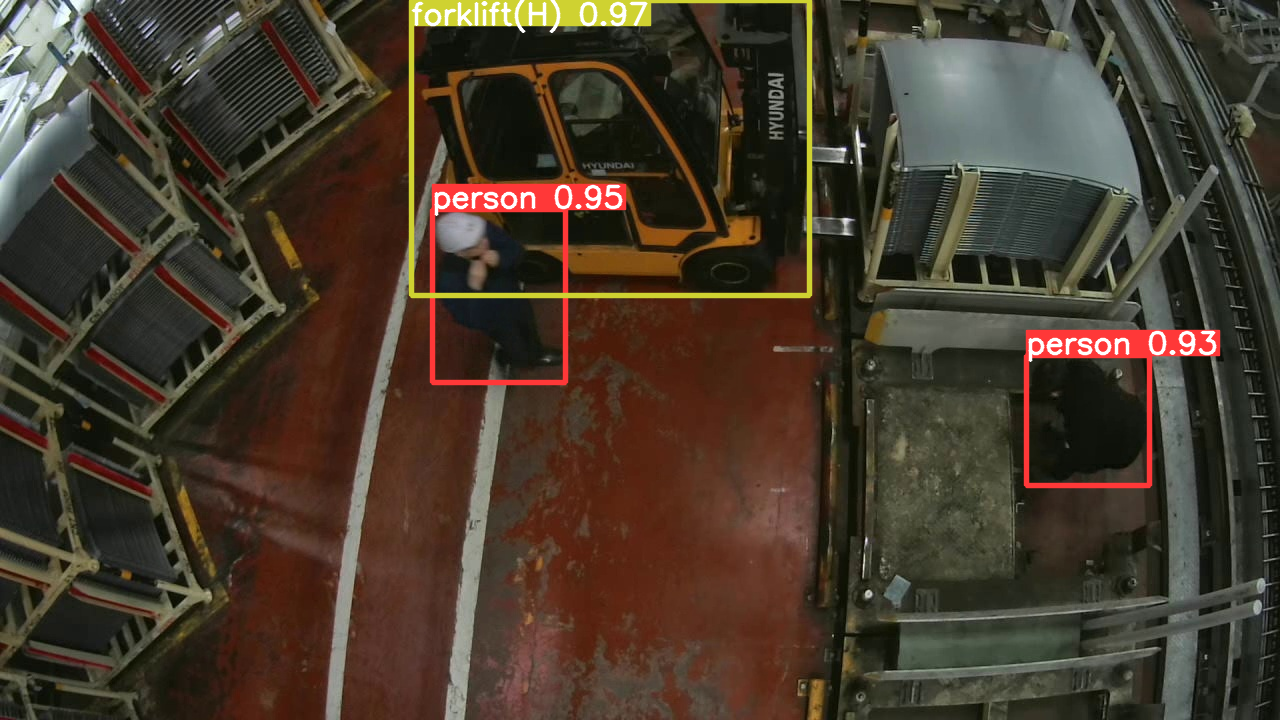

In [33]:
results.show()

In [13]:
### models.common.Detections 속성들
temp = get_attributes_info(results)
for t in temp:
    print(t)

# https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.BaseTensor.__len__
# - boxes : Object containing detection bounding boxes.
# - names : Dictionary of class names.
# - orig_img : Original image as a numpy array.
# - orig_shape : Original image shape in (height, width) format.
# - speed : Dictionary of preprocess, inference, and postprocess speeds (ms/image).

files
ims
n
names
pred
s
t
times
xywh
xywhn
xyxy
xyxyn


In [34]:
results.names

{0: 'person',
 1: 'forklift(V)',
 2: 'Trolly',
 3: 'forklift(D)',
 4: 'forklift(H)'}

In [35]:
results.pred    # (xyxy, conf, cls)

[tensor([[4.11095e+02, 0.00000e+00, 8.09804e+02, 2.95447e+02, 9.70931e-01, 4.00000e+00],
         [4.32363e+02, 2.09945e+02, 5.65312e+02, 3.82837e+02, 9.52751e-01, 0.00000e+00],
         [1.02621e+03, 3.55980e+02, 1.14988e+03, 4.85146e+02, 9.27382e-01, 0.00000e+00]])]

In [53]:
results.pred[0][0][:-2]

tensor([411.09540,   0.00000, 809.80402, 295.44708])

In [68]:
a = results.xywh[0][0][:-2].clone()

In [69]:
results.xywh[0][0][:-2]

tensor([758.17322, 147.72354, 398.70862, 295.44708])

In [72]:
a

tensor([905.89673, 147.72354, 398.70862, 295.44708])

In [71]:
a[0] += a[1]

In [39]:
results.pred[0][:, -1].int().tolist()

[4, 0, 0]

In [23]:
for c in results.xywh:
    c[:-1]

[tensor([[547.43701, 319.57623, 151.49219, 207.49896,   0.95904,   0.00000]])]

In [31]:
for a, b in zip(results.ims, results.pred):
    print(f'a => {type(a)}')
    print(f'b => {b[:, -1].unique()}')

a => <class 'numpy.ndarray'>
b => tensor([0.])


In [54]:
results.pred

[tensor([[6.17738e+02, 1.60674e+00, 8.87833e+02, 2.37194e+02, 7.96737e-01, 1.00000e+00]])]

In [17]:
### ultralytics.engine.results.Boxes 속성들
temp = get_attributes_info(results[0].boxes)
for t in temp:
    print(t)

# https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.Results.summary
# - cls : the class values of the boxes.
# - conf : the confidence values of the boxes.
# - data : the raw tensor containing detection boxes and their associated data.
# - id : the track IDs of the boxes (if available).
# - is_track : 	Indicates whether tracking IDs are included in the box data.
# - orig_shape : The original image size as a tuple (height, width), used for normalization.
# - xywh : the boxes in xywh format.
# - xywhn : the boxes in xywh format normalized by original image size.
# - xyxy : the boxes in xyxy format.
# - xyxyn : the boxes in xyxy format normalized by original image size.

cls
conf
data
id
is_track
orig_shape
shape
xywh
xywhn
xyxy
xyxyn


In [13]:
detect_results[27].boxes.xywh

tensor([[1107.2329,  278.1606,  590.8399,  552.2476]])

In [83]:
detect_results[27].boxes.id

tensor([1.])

In [3]:
### 사진 파일 로드
# img_file = "./datasets/multiple_classes.jpg"
# img = cv2.imread(img_file)

### 사진 예측
# results = model.predict(img, conf=0.5)


0: 384x640 2 Persons, 1 Forklift, 88.5ms
Speed: 4.0ms preprocess, 88.5ms inference, 1578.0ms postprocess per image at shape (1, 3, 384, 640)


In [7]:
### 비디오 예측
# video_file = "./datasets/short.mp4"
# results = model.predict(source= video_file, save=True, conf=0.7, device=DEVICE)



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/224) c:\Users\kdp\PycharmProjects\KDT_MNVISION\BJY\yolo\v9\datasets\short.mp4: 640x640 (no detections), 54.4ms
video 1/1 (frame 2/224) c:\Users\kdp\PycharmProjects\KDT_MNVISION\BJY\yolo\v9\datasets\short.mp4: 640x640 (no detections), 51.9ms
video 1/1 (frame 3/224) c:\Users\kdp\PycharmProjects\KDT_MNVISION\BJY\yolo\v9\datasets\short.mp4: 640x640 1 Forklift(D), 52.6ms
video 1/1 (frame 4/224) c:\Users\kdp\PycharmProjects\KDT_MNVISION\BJY\